In [2]:
# import os
# os.cpu_count()
!nvidia-smi

Wed Nov 30 08:12:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Import Libraries
import numpy as np
import tensorflow as tf

# import tensorflow layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D

In [4]:
# Load Datasets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape) # 4차원 Tensor
## 32 x 32 x 3(RGB-channel) -> 이미지당 pixel 개수.
print(X_test.shape)

170498071/170498071 [==============================] - 13s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Preprocessing

Input Normalization

In [5]:
# min-max scaling
# RGB, 3-channel color [0, 255] 24bit True color, 32bit True color (CYMK)
X_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train[0]

array([[[0.23137255, 0.24313725, 0.24705882],
        [0.16862745, 0.18039216, 0.17647059],
        [0.19607843, 0.18823529, 0.16862745],
        ...,
        [0.61960784, 0.51764706, 0.42352941],
        [0.59607843, 0.49019608, 0.4       ],
        [0.58039216, 0.48627451, 0.40392157]],

       [[0.0627451 , 0.07843137, 0.07843137],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509804, 0.21568627],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117647, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215686, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941176, 0.19607843],
        [0.47058824, 0.32941176, 0.19607843],
        [0.42745098, 0.28627451, 0.16470588]],

       ...,

       [[0.81568627, 0.66666667, 0.37647059],
        [0.78823529, 0.6       , 0.13333333],
        [0.77647059, 0

### Training with Vanilla CNN

**Model Architecture**

> Conv - Relu - Conv - Relu - FC - FC


In [9]:
# Sequential 객체를 이용하여 layer를 쌓아올려 모델을 만듭니다.
model = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(filters=6,
           kernel_size=5, # 5 x 5
           strides=1,
           padding='same', # 0 일 경우, 하얀색 테두리를 두름 # 'same' 을 넣으면 같게 해줌
           activation='relu'),
    Conv2D(16, 5, 1, "same", activation="relu"),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(1024, activation="relu"),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 6)         456       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        2416      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4096)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_5 (Dense)             (None, 128)               131200    
                                                      

In [10]:
# training setup
from tensorflow.keras.optimizers import SGD, Adam

## config variables
batch_size = 128
lr = 1e-4
epochs = 15

# Set optimizer, loss function, metrics, callback function
optimizer = Adam(learning_rate=lr)

# categorical_crossentropy : target value가 이미 one-hot vector인 경우
# sparse_categorical_crossentropy : 그냥 정수

loss_fn = 'sparse_categorical_crossentropy' # multi-class classification
metrics = ['accuracy']

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=metrics)

In [11]:
# model training

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test), # 매 epoch마다 validation 성능 체크 가능!
                    verbose=1)

Epoch 1/15
391/391 [==============================] - 10s 9ms/step - loss: 1.7275 - accuracy: 0.3831 - val_loss: 1.5089 - val_accuracy: 0.4693
Epoch 2/15
391/391 [==============================] - 3s 8ms/step - loss: 1.4238 - accuracy: 0.4976 - val_loss: 1.3524 - val_accuracy: 0.5246
Epoch 3/15
391/391 [==============================] - 3s 7ms/step - loss: 1.2956 - accuracy: 0.5442 - val_loss: 1.2705 - val_accuracy: 0.5500
Epoch 4/15
391/391 [==============================] - 3s 7ms/step - loss: 1.2137 - accuracy: 0.5748 - val_loss: 1.2326 - val_accuracy: 0.5643
Epoch 5/15
391/391 [==============================] - 3s 8ms/step - loss: 1.1466 - accuracy: 0.5971 - val_loss: 1.1551 - val_accuracy: 0.5967
Epoch 6/15
391/391 [==============================] - 3s 8ms/step - loss: 1.0861 - accuracy: 0.6193 - val_loss: 1.1243 - val_accuracy: 0.6040
Epoch 7/15
391/391 [==============================] - 3s 8ms/step - loss: 1.0318 - accuracy: 0.6422 - val_loss: 1.1129 - val_accuracy: 0.6123
Epoch

In [12]:
# evaluate
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print("Loss : %.4f, Accuracy : %.4f" % (loss, acc))

79/79 [==============================] - 0s 5ms/step - loss: 1.0138 - accuracy: 0.6563
Loss : 1.0138, Accuracy : 0.6563


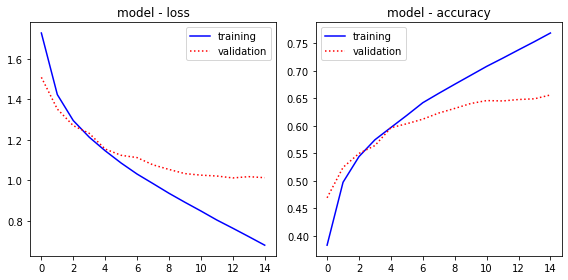

In [13]:
## loss visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1, 2,1)
plt.plot(history.history['loss'],'b-', label = "training")
plt.plot(history.history['val_loss'], 'r:', label = "validation")
plt.title("model - loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("model - accuracy")

plt.plot(history.history['accuracy'], 'b-', label = "training")
plt.plot(history.history['val_accuracy'], 'r:', label = "validation")

plt.legend()
plt.tight_layout()
plt.show()